In [1]:
# Import necessary libraries
from typing import Dict, List, Any
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain.tools import BaseTool
from langchain_core.tools import Tool
# Updated import for memory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory import ChatMessageHistory
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
import re

In [2]:
llm = ChatOllama(model="llama3.2:1b", temperature=0)


In [3]:
class QuestionGeneratorInput(BaseModel):
    language: str = Field(description="Programming language for the question")
    field: str = Field(description="Technical field for the question")
    dsa: str = Field(description="Data structure or algorithm focus")
    difficulty: str = Field(description="Difficulty level: easy, medium, or hard")

class EvaluationInput(BaseModel):
    answer: str = Field(description="User's answer to evaluate")
    question: str = Field(description="The question that was asked")
    difficulty: str = Field(description="Difficulty level of the question")

class QuestionSelectorInput(BaseModel):
    current_difficulty: str = Field(description="Current difficulty level")
    eval_score: int = Field(description="Current evaluation score")
    question_count: int = Field(description="Number of questions asked so far")

class ReportGeneratorInput(BaseModel):
    answers: List[str] = Field(description="List of all user answers")
    eval_scores: List[int] = Field(description="List of evaluation scores")
    difficulty_counts: Dict[str, int] = Field(description="Count of questions by difficulty")

In [4]:
def question_generator(input_data: QuestionGeneratorInput) -> str:
    """Generate a question based on language, field, DSA concept and difficulty level."""
    prompt = f"You are a teacher with expertise in {input_data.language}, {input_data.field}, and {input_data.dsa}. Ask a {input_data.difficulty} level question."
    return llm.invoke(prompt).content

In [5]:
def evaluate_answer(input_data: EvaluationInput) -> Dict[str, Any]:
	"""you are a highly educated expert and your job is to perform strict evaluation of the answer based on the given question"""
	# Simple evaluation logic - can be made more sophisticated
	prompt = f"""you are a highly educated expert and your job is to perform strict evaluation of the answer based on the given question"{input_data.question}" 
	And the answer: "{input_data.answer}"
	Evaluate this {input_data.difficulty} level answer on a scale of 0-10.
	make sure to respond with a number between 0 and 10."""
	score = llm.invoke(prompt)
	try:
		match = re.search(r'\d+', score.content)
		if match:
				return int(match.group())
	except:
		return 5






In [6]:
def choose_next_question(input_data: QuestionSelectorInput) -> Dict[str, Any]:
    """Choose the next question difficulty based on performance."""
    curr_type = input_data.current_difficulty
    eval_score = input_data.eval_score
    question_count = input_data.question_count
    
    if curr_type == "easy" and eval_score >= 5:
        new_type = "medium"
    elif curr_type == "medium":
        if eval_score >= 8:
            new_type = "hard"
        elif eval_score < 5:
            new_type = "easy"
        else:
            new_type = "medium"
    elif curr_type == "hard" and eval_score < 7:
        new_type = "medium"
    else:
        new_type = curr_type

    should_continue = question_count < 15
    
    return {
        "new_difficulty": new_type,
        "should_continue": should_continue
    }

In [7]:
def generate_final_report(input_data: ReportGeneratorInput) -> str:
    """Generate a final report of the user's performance."""
    prompt = f"""Based on these answers and scores, write a short evaluation highlighting strengths, weaknesses, and areas for improvement:
    - Number of easy questions answered: {input_data.difficulty_counts.get('easy', 0)}
    - Number of medium questions answered: {input_data.difficulty_counts.get('medium', 0)}
    - Number of hard questions answered: {input_data.difficulty_counts.get('hard', 0)}
    - Average score: {sum(input_data.eval_scores) / len(input_data.eval_scores) if input_data.eval_scores else 0}
    """
    return llm.invoke(prompt).content

In [8]:
system_prompt = """You are an adaptive quiz agent. Your job is to:
1. Ask questions about programming topics based on language, field, and data structures/algorithms
2. Evaluate user answers
3. Adjust difficulty based on performance
4. Generate a final report after 15 questions

Follow this process:
1. Start with an easy question about the specified language, field, and DSA concept
2. After receiving an answer, evaluate it
3. Determine the next question's difficulty based on performance
4. After 15 questions, generate a final report

Track the following:
- Current difficulty level (starts as "easy")
- Total evaluation score
- Question count
- Number of easy/medium/hard questions answered
- List of all answers and their evaluation scores

When generating the final report, analyze the user's performance and provide specific feedback.
You have to ask the questions and evaluate answers
"""

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START, END
from langgraph.graph.message import add_messages


class chatstate(TypedDict):
	messages: Annotated[list, add_messages]


graph = StateGraph(chatstate)


In [10]:
def end_quiz(i):
    if i<15:
        return "next question"
    else:
        return "create report"
    

In [11]:
graph.add_node("question_generator",question_generator)
graph.add_node("evaluate_answer",evaluate_answer)
graph.add_node("choose_next_question",choose_next_question)
graph.add_node("generate_final_report",generate_final_report)



In [12]:

graph.add_edge(START,"question_generator")
graph.add_edge("question_generator","evaluate_answer")
graph.add_edge("evaluate_answer","choose_next_question")
# graph.add_edge("choose_next_question","question_generator")


In [13]:
graph.add_conditional_edges("choose_next_question",
                            end_quiz,{
                                
																												
                            "next question": "question_generator",
                            "create report" : "generate_final_report"
																												}
                            )

In [14]:
builder = graph.compile()

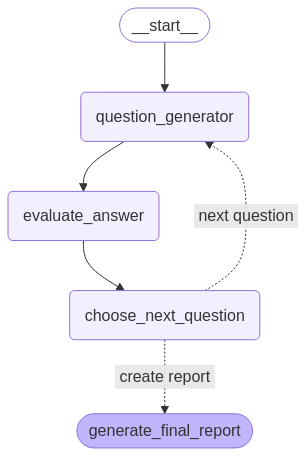

In [15]:
from IPython.display import Image, display

display(Image(builder.get_graph().draw_mermaid_png()))

In [16]:
builder.invoke()

TypeError: Pregel.invoke() missing 1 required positional argument: 'input'